In [2]:
import pandas as pd
import plotly.express as px
from sklearn import preprocessing
#from pmdarima.arima import auto_arima
from datetime import timedelta
import warnings
import plotly.graph_objects as go

warnings.filterwarnings(
    "ignore", category=pd.core.common.SettingWithCopyWarning)
warnings.simplefilter(
    "ignore", UserWarning)


def serve_data(ret=False):
    global JHU_RECENT
    global DATE_MAPPER
    global JHU_TIME
    global CSBS
    global CENTROID_MAPPER
    global MERGED_CSBS_JHU
    global JHU_DF_AGG_COUNTRY
    global JHU_DF_AGG_PROVINCE
    global CSBS_DF_AGG_STATE
    global CSBS_DF_AGG_COUNTY

    jhu_df = pd.read_csv(
        'https://jordansdatabucket.s3-us-west-2.amazonaws.com/covid19data/jhu_df.csv.gz', index_col=0)
    jhu_df_time = pd.read_csv(
        'https://jordansdatabucket.s3-us-west-2.amazonaws.com/covid19data/jhu_df_time.csv.gz', index_col=0)
    csbs_df = pd.read_csv(
        'https://jordansdatabucket.s3-us-west-2.amazonaws.com/covid19data/csbs_df.csv.gz', index_col=0)

    jhu_df_time['Date'] = pd.to_datetime(jhu_df_time['Date'])
    jhu_df['Date'] = pd.to_datetime(jhu_df['Date'])
    csbs_df['Date'] = pd.to_datetime(csbs_df['Date'])

    date_mapper = pd.DataFrame(
        jhu_df_time['Date'].unique(), columns=['Date'])
    date_mapper['Date_text'] = date_mapper['Date'].dt.strftime('%m/%d/%y')

    # JHU and CSBS are out of sync, so we should use the latest date from JHU
    latest_date = jhu_df_time.sort_values('Date')['Date'].iloc[-1]
    merge = pd.concat([jhu_df, csbs_df[csbs_df['Date'] == latest_date]])
    merge = merge.fillna('')

    # Countries without a code may be a problem
    problem_countries = merge[merge['country_code'] == '']['country'].tolist()

    # I know for a fact Namibia has no coud
    merge.loc[merge['country'] == 'Namibia', 'country_code'] = ''

    # Lets grab the centroids from this great spread sheet
    centroid_mapper = pd.read_csv('../country_centroids_az8.csv')
    problem_states = merge[~merge['country_code'].isin(
        centroid_mapper['iso_a2'])]
    new_merge = merge.merge(
        centroid_mapper, left_on='country_code', right_on='iso_a2')

    # If something is has the same name for continent and subregion, lets just add the word _subregion
    new_merge.loc[new_merge['continent'] == new_merge['subregion'],
                  'subregion'] = new_merge['subregion'] + ' Subregion'

    # # Lets remove the US Data since we are doubel counting htis by merging CSBSS
    new_merge_no_us = new_merge[~((new_merge['country'] == 'US') & (
        new_merge['province'] == ''))]
    MERGED_CSBS_JHU = new_merge
    JHU_TIME = jhu_df_time
    JHU_RECENT = jhu_df
    DATE_MAPPER = date_mapper
    CSBS = csbs_df
    CENTROID_MAPPER = centroid_mapper

    JHU_DF_AGG_COUNTRY = pd.read_csv(
        'https://jordansdatabucket.s3-us-west-2.amazonaws.com/covid19data/JHU_DF_AGG_COUNTRY.csv.gz', index_col=0)

    JHU_DF_AGG_PROVINCE =  pd.read_csv(
        'https://jordansdatabucket.s3-us-west-2.amazonaws.com/covid19data/JHU_DF_AGG_PROVINCE.csv.gz', index_col=0)


    CSBS_DF_AGG_STATE = pd.read_csv(
        'https://jordansdatabucket.s3-us-west-2.amazonaws.com/covid19data/CSBS_DF_AGG_STATE.csv.gz', index_col=0, parse_dates=['Date'])

    CSBS_DF_AGG_COUNTY = pd.read_csv(
        'https://jordansdatabucket.s3-us-west-2.amazonaws.com/covid19data/CSBS_DF_AGG_COUNTY.csv.gz', index_col=0, parse_dates=['Date'])

    if ret:
        return JHU_RECENT, JHU_TIME, CSBS, DATE_MAPPER
serve_data()

In [6]:
gb = JHU_DF_AGG_COUNTRY.groupby('country')

In [19]:
import multiprocessing

def run_prediction(sub_df):
    print('Running', sub_df['country'].iloc[0])
    return ""
    prediction_df = predict(sub_df, 7)
    return pd.concat([sub_df, prediction_df]).ffill().fillna(0)


predicitons_dfs = []
gb = JHU_DF_AGG_COUNTRY.groupby('country')
pool = multiprocessing.Pool()
print("Running MP on countries")
test = pd.concat(pool.map(run_prediction,[i[1] for i in gb]))

Running Afghanistan
Running Argentina
Running Bahrain
Running Armenia
Running Benin
Running Bangladesh
Running Albania
Running Brunei
Running China
Running Cambodia
Running Bhutan
Running Australia
Running Algeria
Running Barbados
Running Bulgaria
Running Cameroon
Running Colombia
Running Croatia
Running Bolivia
Running Austria
Running Belarus
Running Andorra
Running Burkina Faso
Running Congo (Brazzaville)
Running Canada
Running Cuba
Running Bosnia and Herzegovina
Running Azerbaijan
Running Belgium
Running Burma
Running Central African Republic
Running Angola
Running Congo (Kinshasa)
Running Cyprus
Running Bahamas
Running Burundi
Running Antigua and Barbuda
Running Chad
Running Czechia
Running Belize
Running Botswana
Running Costa Rica
Running Cabo Verde
Running Chile
Running Cote d'Ivoire
Running Denmark
Running Brazil
Running Equatorial Guinea
Running Djibouti
Running Finland
Running Diamond Princess
Running Ghana
Running Guyana
Running Eritrea
Running Dominica
Running France
Runnin

TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [22]:
pd.read_csv('../Data/TestJHU_DF_AGG_COUNTRY.csv.gz',index_col=0)

,Date,country,lat,lon,confirmed,deaths,forcast,confirmed_upper,confirmed_lower,deaths_upper,deaths_lower
0,2020-01-22,Afghanistan,33.0,65.0,0.000000,0.000000,False,0.000000,0.000000,0.000000,0.000000
184,2020-01-23,Afghanistan,33.0,65.0,0.000000,0.000000,False,0.000000,0.000000,0.000000,0.000000
368,2020-01-24,Afghanistan,33.0,65.0,0.000000,0.000000,False,0.000000,0.000000,0.000000,0.000000
552,2020-01-25,Afghanistan,33.0,65.0,0.000000,0.000000,False,0.000000,0.000000,0.000000,0.000000
736,2020-01-26,Afghanistan,33.0,65.0,0.000000,0.000000,False,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2,2020-04-12,Zimbabwe,-20.0,30.0,11.461304,3.405133,True,12.828752,10.093856,4.045891,2.764375
3,2020-04-13,Zimbabwe,-20.0,30.0,11.803875,3.544946,True,13.330582,10.277168,4.289394,2.800498
4,2020-04-14,Zimbabwe,-20.0,30.0,12.132804,3.687144,True,13.846215,10.419394,4.524535,2.849754
5,2020-04-15,Zimbabwe,-20.0,30.0,12.416013,3.831726,True,14.428954,10.403071,4.754565,2.908888


In [393]:
import plotly
colors = plotly.colors.qualitative.Dark24
colors.remove(colors[5])
colors = colors * 10

def get_rgb_with_opacity(hex_color,opacity=0.5):
    h = hex_color.lstrip('#')
    return 'rgba'+'{}'.format(tuple(list(int(h[i:i+2], 16) for i in (0, 2, 4))+[opacity]))


In [564]:
def plot(df, plot_me, locator):
    fig = go.Figure()
    for enum_, name in enumerate(plot_me):
        sub_df = df[df[locator] == name]
        color_ = colors[enum_]

        color_rgba = get_rgb_with_opacity(color_,opacity=0.2)
        ##Add error:
        ##To connect a shape we have to go forward and back
        forcast = sub_df[sub_df['forcast'] == True]

        dates = list(forcast['Date'])
        xs = dates + dates[::-1]
        uppers = list(forcast['confirmed_upper'])
        lowers = list(forcast['confirmed_lower'])
        ys = uppers + lowers[::-1]
        fig.add_trace(
            go.Scatter(
                x=xs,
                y=ys,
                fill='toself',
                hoverinfo='none',
                fillcolor=color_rgba,
                line_color='rgba(255,255,255,0)',
                showlegend=False,
            ))

        ##Add full line with prediction:
        fig.add_trace(
            go.Scatter(
                x=sub_df['Date'],
                y=sub_df['confirmed'],
                showlegend=False,
                mode='lines+markers',
                marker=dict(
                    color='rgba(255,255,255,0)',
                    size=8,
                    line=dict(
                        width=2,
                        color=color_,
                    )),
                line=dict(
                    color=color_,
                    width=1,
                    dash='dashdot'
                )))

        sub_df = sub_df[sub_df['forcast'] == False]
        ##Add full line without prediction:
        fig.add_trace(
            go.Scatter(
                x=sub_df['Date'],
                y=sub_df['confirmed'],
                showlegend=False,
                mode='lines+markers',
                marker=dict(
                    color=color_,
                    size=8,
                    line=dict(
                        width=2,
                        color=color_,
                    )),
                line=dict(
                    color=color_,
                    width=2,
                    dash='solid'
                )))

    fig.update_layout(title='Average High and Low Temperatures in New York',
                       xaxis_title='Month',
                       yaxis_title='Temperature (degrees F)')
    return fig



In [474]:
JHU_DF_AGG_COUNTRY = JHU_TIME.sort_values('confirmed')[::-1].groupby(['Date', 'country']).agg(
    {'lat': 'first', 'lon': 'first', 'confirmed': 'sum', 'deaths': 'sum'}).reset_index()

JHU_DF_AGG_PROVINCE = JHU_TIME[JHU_TIME['province'] != ''].sort_values('confirmed')[::-1].groupby(['Date', 'country', 'province']).agg(
    {'lat': 'first', 'lon': 'first', 'confirmed': 'sum', 'deaths': 'sum'}).reset_index()

CSBS_DF_AGG_STATE = CSBS[CSBS['province'] != ''].sort_values('confirmed')[::-1].groupby(['Date', 'country', 'province']).agg(
    {'lat': 'first', 'lon': 'first', 'confirmed': 'sum', 'deaths': 'sum'}).reset_index().rename({'province': 'state'}, axis=1)

CSBS_DF_AGG_COUNTY = CSBS[CSBS['county'] != ''].sort_values('confirmed')[::-1].groupby(['Date', 'country', 'province', 'county']).agg(
    {'lat': 'first', 'lon': 'first', 'confirmed': 'sum', 'deaths': 'sum'}).reset_index()

In [565]:
def predict(sub_df, days):
    sub_df['forcast'] = False
    base_date = sub_df.sort_values('Date')['Date'].iloc[-1]
    date_list = [base_date +
                 timedelta(days=x) for x in range(1, days+1)]
    forcasts = []
    upper_bounds = []
    lower_bounds = []
    for metric in ['confirmed', 'deaths']:
        train = np.append(sub_df[metric], np.zeros(days))
        fit = sub_df[metric]
        stepwise_model = auto_arima(
            fit,
            seasonal=False,
            trace=False,
            out_of_sample_size=2,
            error_action='ignore',
            suppress_warnings=True)
        model_fit = stepwise_model.fit(fit)
        forcast, conf = model_fit.predict(days, return_conf_int=True)
        forcasts.append(forcast)
        upper_bounds.append(conf[:, 1])
        lower_bounds.append(conf[:, 0])
    return pd.DataFrame({'Date': date_list,
                         'confirmed': forcasts[0],
                         'confirmed_upper': upper_bounds[0],
                         'confirmed_lower': lower_bounds[0],
                         'deaths': forcasts[1],
                         'deaths_upper': upper_bounds[1],
                         'deaths_lower': lower_bounds[1],
                         'forcast': True}).ffill().reset_index(drop=True)

In [566]:
predicitons_dfs = []
gb = JHU_DF_AGG_COUNTRY.groupby('country')
for country in gb.groups.keys():
    sub_df = gb.get_group(country)
    predictions_df = predict(sub_df,7)
    predicitons_dfs.append(pd.concat([sub_df,predictions_df]).ffill().fillna(0))
    print('predicted {}'.format(country))


predicted Afghanistan
predicted Albania
predicted Algeria


KeyboardInterrupt: 

In [552]:
predicitons_dfs = []
gb = JHU_DF_AGG_PROVINCE.groupby(['country','province'])
for province in gb.groups.keys():
    sub_df = gb.get_group(province)
    predictions_df = predict(sub_df,7)
    predicitons_dfs.append(pd.concat([sub_df,predictions_df]).ffill().fillna(0))
    print('predicted {}'.format(province))
province_df = pd.concat(predicitons_dfs)

predicted ('Australia', 'Australian Capital Territory')
predicted ('Australia', 'New South Wales')
predicted ('Australia', 'Northern Territory')
predicted ('Australia', 'Queensland')
predicted ('Australia', 'South Australia')
predicted ('Australia', 'Tasmania')
predicted ('Australia', 'Victoria')
predicted ('Australia', 'Western Australia')
predicted ('Canada', 'Alberta')
predicted ('Canada', 'British Columbia')
predicted ('Canada', 'Diamond Princess')
predicted ('Canada', 'Grand Princess')
predicted ('Canada', 'Manitoba')
predicted ('Canada', 'New Brunswick')
predicted ('Canada', 'Newfoundland and Labrador')
predicted ('Canada', 'Northwest Territories')
predicted ('Canada', 'Nova Scotia')
predicted ('Canada', 'Ontario')
predicted ('Canada', 'Prince Edward Island')
predicted ('Canada', 'Quebec')
predicted ('Canada', 'Recovered')
predicted ('Canada', 'Saskatchewan')
predicted ('Canada', 'Yukon')
predicted ('China', 'Anhui')
predicted ('China', 'Beijing')
predicted ('China', 'Chongqing')

In [555]:
predicitons_dfs = []
gb = CSBS_DF_AGG_STATE.groupby(['country','state'])
for province in gb.groups.keys():
    sub_df = gb.get_group(province)
    predictions_df = predict(sub_df,7)
    predicitons_dfs.append(pd.concat([sub_df,predictions_df]).ffill().fillna(0))
    print('predicted {}'.format(province))
state_df = pd.concat(predicitons_dfs)

predicted ('US', 'Alabama')
predicted ('US', 'Alaska')
predicted ('US', 'Arizona')
predicted ('US', 'Arkansas')
predicted ('US', 'California')
predicted ('US', 'Colorado')
predicted ('US', 'Connecticut')
predicted ('US', 'Delaware')
predicted ('US', 'District of Columbia')
predicted ('US', 'Florida')
predicted ('US', 'Georgia')
predicted ('US', 'Guam')
predicted ('US', 'Hawaii')
predicted ('US', 'Idaho')
predicted ('US', 'Illinois')
predicted ('US', 'Indiana')
predicted ('US', 'Iowa')
predicted ('US', 'Kansas')
predicted ('US', 'Kentucky')
predicted ('US', 'Louisiana')
predicted ('US', 'Maine')
predicted ('US', 'Maryland')
predicted ('US', 'Massachusetts')
predicted ('US', 'Michigan')
predicted ('US', 'Minnesota')
predicted ('US', 'Mississippi')
predicted ('US', 'Missouri')
predicted ('US', 'Montana')
predicted ('US', 'Navajo Nation')
predicted ('US', 'Nebraska')
predicted ('US', 'Nevada')
predicted ('US', 'New Hampshire')
predicted ('US', 'New Jersey')
predicted ('US', 'New Mexico')
p

In [557]:
CSBS_DF_AGG_COUNTY

,Date,country,province,county,lat,lon,confirmed,deaths
0,2020-01-22,US,Alabama,Autauga,32.534893,-86.642709,0.0,0.0
1,2020-01-22,US,Alabama,Baldwin,30.735891,-87.723525,0.0,0.0
2,2020-01-22,US,Alabama,Barbour,31.869190,-85.397182,0.0,0.0
3,2020-01-22,US,Alabama,Bibb,32.998624,-87.126430,0.0,0.0
4,2020-01-22,US,Alabama,Blount,33.980852,-86.567391,0.0,0.0
...,...,...,...,...,...,...,...,...
209893,2020-04-08,US,Wyoming,Sweetwater,41.661309,-108.876894,6.0,0.0
209894,2020-04-08,US,Wyoming,Teton,43.918851,-110.596260,44.0,0.0
209895,2020-04-08,US,Wyoming,Uinta,41.287478,-110.547671,3.0,0.0
209896,2020-04-08,US,Wyoming,Washakie,43.904950,-107.683110,5.0,0.0


In [560]:
predicitons_dfs = []
gb = CSBS_DF_AGG_COUNTY.groupby(['country','province','county'])
for province in gb.groups.keys():
    sub_df = gb.get_group(province)
    predictions_df = predict(sub_df,7)
    predicitons_dfs.append(pd.concat([sub_df,predictions_df]).ffill().fillna(0))
    print('predicted {}'.format(province))
county_df = pd.concat(predicitons_dfs)

predicted ('US', 'Alabama', 'Autauga')
predicted ('US', 'Alabama', 'Baldwin')
predicted ('US', 'Alabama', 'Barbour')
predicted ('US', 'Alabama', 'Bibb')
predicted ('US', 'Alabama', 'Blount')
predicted ('US', 'Alabama', 'Bullock')
predicted ('US', 'Alabama', 'Butler')
predicted ('US', 'Alabama', 'Calhoun')
predicted ('US', 'Alabama', 'Chambers')
predicted ('US', 'Alabama', 'Cherokee')
predicted ('US', 'Alabama', 'Chilton')
predicted ('US', 'Alabama', 'Choctaw')
predicted ('US', 'Alabama', 'Clarke')
predicted ('US', 'Alabama', 'Clay')
predicted ('US', 'Alabama', 'Cleburne')
predicted ('US', 'Alabama', 'Coffee')
predicted ('US', 'Alabama', 'Colbert')
predicted ('US', 'Alabama', 'Conecuh')
predicted ('US', 'Alabama', 'Coosa')
predicted ('US', 'Alabama', 'Covington')
predicted ('US', 'Alabama', 'Crenshaw')
predicted ('US', 'Alabama', 'Cullman')
predicted ('US', 'Alabama', 'Dale')
predicted ('US', 'Alabama', 'Dallas')
predicted ('US', 'Alabama', 'DeKalb')
predicted ('US', 'Alabama', 'Elmore'

KeyboardInterrupt: 

In [549]:
plot(countries_df,['Italy','US'],'country')

[Timestamp('2020-01-22 00:00:00'),
 Timestamp('2020-01-23 00:00:00'),
 Timestamp('2020-01-24 00:00:00'),
 Timestamp('2020-01-25 00:00:00'),
 Timestamp('2020-01-26 00:00:00'),
 Timestamp('2020-01-27 00:00:00'),
 Timestamp('2020-01-28 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-01-30 00:00:00'),
 Timestamp('2020-01-31 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-02-02 00:00:00'),
 Timestamp('2020-02-03 00:00:00'),
 Timestamp('2020-02-04 00:00:00'),
 Timestamp('2020-02-05 00:00:00'),
 Timestamp('2020-02-06 00:00:00'),
 Timestamp('2020-02-07 00:00:00'),
 Timestamp('2020-02-08 00:00:00'),
 Timestamp('2020-02-09 00:00:00'),
 Timestamp('2020-02-10 00:00:00'),
 Timestamp('2020-02-11 00:00:00'),
 Timestamp('2020-02-12 00:00:00'),
 Timestamp('2020-02-13 00:00:00'),
 Timestamp('2020-02-14 00:00:00'),
 Timestamp('2020-02-15 00:00:00'),
 Timestamp('2020-02-16 00:00:00'),
 Timestamp('2020-02-17 00:00:00'),
 Timestamp('2020-02-18 00:00:00'),
 Timestamp('2020-02-

'rgba(46, 145, 229, 0.5)'

In [361]:
import numpy as np



x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x_rev = x[::-1]

# Line 1
y1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1_upper = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y1_lower = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y1_lower = y1_lower[::-1]

# Line 2
y2 = [5, 2.5, 5, 7.5, 5, 2.5, 7.5, 4.5, 5.5, 5]
y2_upper = [5.5, 3, 5.5, 8, 6, 3, 8, 5, 6, 5.5]
y2_lower = [4.5, 2, 4.4, 7, 4, 2, 7, 4, 5, 4.75]
y2_lower = y2_lower[::-1]

# Line 3
y3 = [10, 8, 6, 4, 2, 0, 2, 4, 2, 0]
y3_upper = [11, 9, 7, 5, 3, 1, 3, 5, 3, 1]
y3_lower = [9, 7, 5, 3, 1, -.5, 1, 3, 1, -1]
y3_lower = y3_lower[::-1]


fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y1_upper+y1_lower,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Fair',
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y2_upper+y2_lower,
    fill='toself',
    fillcolor='rgba(0,176,246,0.2)',
    line_color='rgba(255,255,255,0)',
    name='Premium',
    showlegend=False,
))
fig.add_trace(go.Scatter(
    x=x+x_rev,
    y=y3_upper+y3_lower,
    fill='toself',
    fillcolor='rgba(231,107,243,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Ideal',
))
fig.add_trace(go.Scatter(
    x=x, y=y1,
    line_color='rgb(0,100,80)',
    name='Fair',
))
fig.add_trace(go.Scatter(
    x=x, y=y2,
    line_color='rgb(0,176,246)',
    name='Premium',
))
fig.add_trace(go.Scatter(
    x=x, y=y3,
    line_color='rgb(231,107,243)',
    name='Ideal',
))

fig.update_traces(mode='lines')
fig.show()

In [376]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=xs,
    y=ys,
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    name='Fair',
))

In [149]:
le = preprocessing.LabelEncoder()
country_df = JHU_TIME.groupby(['country','Date']).sum().reset_index().drop(['lat','lon','county'],axis=1).sort_values(['country','Date']).reset_index().rename({'index':'Id'},axis=1)


#Encode Dates
country_df['Day_num'] = le.fit_transform(country_df['Date'])

##Get dictionary of Day for quick lookup
number_d = country_df['Day_num']
dates = le.inverse_transform(country_df['Day_num'])
date_dict = dict(zip(dates, number_d)) 



#Encode Countries
country_df['country_num'] = le.fit_transform(country_df['country'])
##Get dictionary of country number for quick lookup
number_c = country_df['country_num']
countries = le.inverse_transform(country_df['country_num'])
country_dict = dict(zip(countries, number_c)) 

## 3.2. Compute lags and trends <a id="section32"></a>

Enriching a dataset is key to obtain good results. In this case we will apply 2 different transformations:

**Lag**. Lags are a way to compute the previous value of a column, so that the lag 1 for ConfirmedCases would inform the this column from the previous day. The lag 3 of a feature X is simply:
$$X_{lag3}(t) = X(t-3)$$


**Trend**. Transformig a column into its trend gives the natural tendency of this column, which is different from the raw value. The definition of trend I will apply is: 
$$Trend_{X} = {X(t) - X(t-1) \over X(t-1)}$$

The backlog of lags I'll apply is 14 days, while for trends is 7 days.  For ConfirmedCases and Fatalities:

In [150]:
def calculate_lag(df,lag_list,column):
    for lag in lag_list:
        df['Lag_{}_{}'.format(lag,column)] = df.groupby(['country'])[column].shift(lag,fill_value=0)
    return df

def calculate_trend(df,lag_list,column):
    for lag in lag_list:
        xt = df[column]
        xt_lag = df.groupby('country')[column].shift(lag,fill_value=0)
        xt_lag_round = df.groupby('country')[column].shift(lag,fill_value=0.001)
        df['Trend_{}_{}'.format(lag,column)] = (xt - xt_lag)/xt_lag_round
    return df

country_df = calculate_lag(country_df,range(1,8),'confirmed')
country_df = calculate_lag(country_df,range(1,8),'deaths')
country_df = calculate_trend(country_df,range(1,8),'confirmed')
country_df = calculate_trend(country_df,range(1,8),'deaths')

In [79]:
gb = country_df.groupby('country')
days_past_df = []
for countries in country_df['country'].unique():
    sub_df = gb.get_group(countries)
    sub_df = sub_df[sub_df['confirmed'] > 100].sort_values('Date').reset_index(drop=True).reset_index().rename({'index':'Days'},axis=1)
    days_past_df.append(sub_df)
days_past_df = pd.concat(days_past_df)

plot = days_past_df[days_past_df['country'].isin(['China','US','Italy','Spain','Germany'])]
fig = px.line(plot, x="Days", y="confirmed",color='country', title='Day 0 is first day past 100 infections')
fig.show()

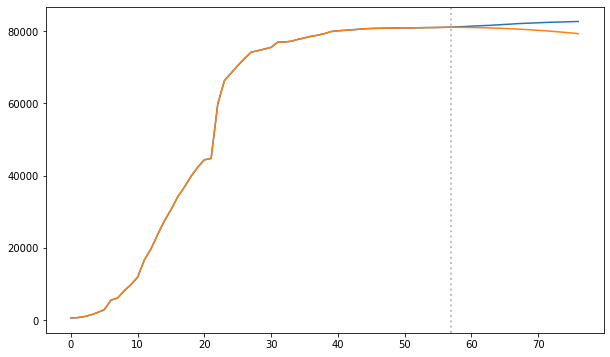

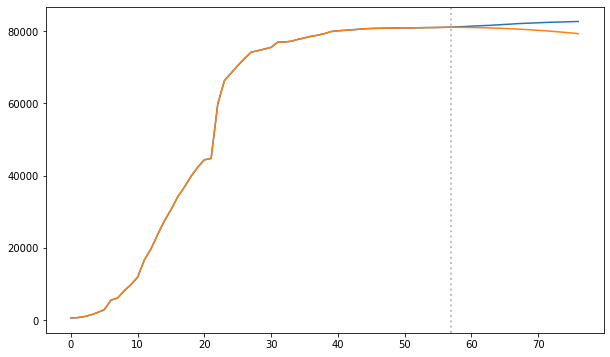

In [230]:
def plot_country(country,td=10):
    us_only = country_df[country_df['country'] == country]

    forcast_days = 10
    train_days = td
    confirmed  = us_only['confirmed']

    # ##This will be our full parameters which is all our known confirmed cases plus some zeros
    #full_params = np.append(us_only['confirmed'],np.zeros(forcast_days))

    #Train split will  substract a few days so we can guess what those values are
    train_split = us_only['confirmed'][0:-(train_days)]

    #The test split wil be our last few days
    test_split = us_only['confirmed'][-train_days::]

    stepwise_model = auto_arima(
        np.append(train_split,np.zeros(20)),
        start_p=1,
        start_q=1, 
        max_p=30, 
        max_q=30,
        start_P=0, 
        seasonal=False,
        d=2,
        trace=False,
        error_action='ignore',
        suppress_warnings=True)
    stepwise_model.fit(train_split)

    dates = range(0,len(confirmed))
    fig, (ax1) = plt.subplots(1, 1, figsize=(10,6))
    ax1.plot(dates, confirmed)
    ax1.plot(dates, np.append(confirmed[0:-td],stepwise_model.predict(td)))
    ax1.axvline(len(dates)-td,linewidth=2,ls=":",color='grey',alpha=0.5)
    return fig
plot_country('China',td=20)

# fit_minus_10 = stepwise_model.fit(us_only['confirmed'])